<a href="https://colab.research.google.com/github/Acesarsilva/EDA_Credit/blob/main/Projetao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Organização dos arquivos

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

Baixando os arquivos

In [31]:
file = 'drive/MyDrive/TRNcod.csv'
df = pd.read_csv(file)

Remoção da coluna INDEX

In [32]:
df = df.drop(['INDEX'], axis = 1)

In [33]:
df.head()

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,NIVEL_RELACIONAMENTO_CREDITO02,BANCO_REST_IRPF_ULTIMA_1,BANCO_REST_IRPF_ULTIMA_2,BANCO_REST_IRPF_ULTIMA_3,BANCO_REST_IRPF_ULTIMA_4,BANCO_REST_IRPF_ULTIMA_5,BANCO_REST_IRPF_ULTIMA_6,BANCO_REST_IRPF_ULTIMA_7,ATIVIDADE_EMAIL,EXPOSICAO_ENDERECO,EXPOSICAO_EMAIL,EXPOSICAO_TELEFONE,ATIVIDADE_ENDERECO,ATUALIZACAO_ENDERECO,ATUALIZACAO_EMAIL,EXPOSICAO_CONSUMIDOR_EMAILS,EXPOSICAO_CONSUMIDOR_TELEFONES,ATIVIDADE_TELEFONE,VALOR_PARCELA_BOLSA_FAMILIA,FLAG_BOLSA_FAMILIA_1,SIGLA_PARTIDO_FILIADO_1,SIGLA_PARTIDO_FILIADO_2,SIGLA_PARTIDO_FILIADO_3,SIGLA_PARTIDO_FILIADO_4,SIGLA_PARTIDO_FILIADO_5,SIGLA_PARTIDO_FILIADO_6,SIGLA_PARTIDO_FILIADO_7,FLAG_FILIADO_PARTIDO_POLITICO_1,FLAG_PROUNI_1,RENDA_VIZINHANCA_1,...,CEP1_3,CEP1_4,CEP1_5,CEP2_1,CEP2_2,CEP2_3,CEP2_4,CEP2_5,CEP2_6,CEP2_7,CEP2_8,CEP2_9,CEP3_1,CEP3_2,CEP3_3,CEP3_4,CEP3_5,CEP3_6,CEP3_7,CEP3_8,CEP3_9,CEP3_10,CEP3_11,CEP3_12,CEP4_1,CEP4_2,CEP4_3,CEP4_4,CEP4_5,CEP4_6,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
0,1,1,1,0,0,0,0,0.135098,1,0.222222,0.0,0,0,0,0,0,1,1,5.881235e-18,0.041667,0.000000,0.000000,0.105588,0.796392,-5.140958e-17,0.0,0.1,1.316491e-01,0.000000,0,1,1,1,0,0,0,0,0,1,0,...,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,1,0,1,1,1,0,1
1,1,0,1,0,0,1,0,0.273504,1,0.111111,0.0,0,0,0,0,0,1,1,5.881235e-18,0.013889,0.000000,0.000000,0.147356,0.979968,-5.140958e-17,0.0,0.0,-2.188272e-17,0.000000,0,1,1,1,0,0,0,0,0,0,0,...,0,1,0,1,1,1,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,1,0,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1,0
2,1,0,1,0,0,1,0,0.281910,0,1.000000,0.0,0,0,0,0,0,1,1,5.881235e-18,0.500000,0.000000,0.000000,0.147356,0.398645,-5.140958e-17,0.0,0.0,-2.188272e-17,0.000000,0,1,1,1,0,0,0,0,0,0,0,...,0,1,0,1,1,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,1,1,0,1,1,0,1,1,0,0,0,0,1,0,1,0
3,1,1,1,0,0,0,0,0.225741,0,0.111111,0.0,1,1,0,0,0,0,0,4.788559e-01,0.083333,0.115789,0.055556,0.147356,0.398645,8.325188e-02,0.2,0.3,4.859488e-01,0.000000,0,1,1,1,0,0,0,0,0,1,0,...,1,0,0,1,1,0,0,0,0,1,1,0,1,0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,1,0,1,1,0,1,0,1,0
4,1,1,0,0,0,1,0,0.480403,0,0.111111,0.0,0,0,0,0,0,1,1,5.881235e-18,0.208333,0.000000,0.111111,0.151604,0.398645,-5.140958e-17,0.0,0.5,1.689438e-01,0.458333,1,1,1,1,0,0,0,0,0,1,0,...,1,0,1,0,1,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,1,1,0,0,0,0,1,1,1,1,0,0,1,0,1,1,0


Separação das classes pelo critério da primeira columa 'IND_BOM_1_1'

In [34]:
classe1 = df[df['IND_BOM_1_1'] == 1]
classe2 = df[df['IND_BOM_1_1'] == 0]

In [35]:
import numpy as np

Separação dos dados das classes pelas porcentagens 50%, 25% e 25%

In [36]:
[a1, b1, c1] = np.split(classe1, [int(classe1.shape[0]*0.5),int(classe1.shape[0]*0.75)])
[a2, b2, c2] = np.split(classe2, [int(classe2.shape[0]*0.5),int(classe2.shape[0]*0.75)])

print(a1.shape, b1.shape, c1.shape)
print(a2.shape, b2.shape, c2.shape)

(127549, 245) (63774, 245) (63775, 245)
(67049, 245) (33524, 245) (33525, 245)


Duplicação dos dados que precisavam ser duplicados

In [37]:
a2 = pd.concat([a2]*2)
b2 = pd.concat([b2]*2)

In [38]:
print(a1.shape, b1.shape, c1.shape)
print(a2.shape, b2.shape, c2.shape)

(127549, 245) (63774, 245) (63775, 245)
(134098, 245) (67048, 245) (33525, 245)


Junção das classes

In [39]:
train = pd.concat([a1, a2])
test = pd.concat([b1, b2])
validation = pd.concat([c1, c2])
print(train.shape, test.shape, validation.shape)

(261647, 245) (130822, 245) (97300, 245)


Mistura das linhas para deixar os dados mais heterogêneos 

In [40]:
train = train.sample(frac = 1)
test = test.sample(frac = 1)
validation = validation.sample(frac = 1)

# Shap + XGBoost

In [ ]:
train.head()

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,NIVEL_RELACIONAMENTO_CREDITO02,BANCO_REST_IRPF_ULTIMA_1,BANCO_REST_IRPF_ULTIMA_2,BANCO_REST_IRPF_ULTIMA_3,BANCO_REST_IRPF_ULTIMA_4,BANCO_REST_IRPF_ULTIMA_5,BANCO_REST_IRPF_ULTIMA_6,BANCO_REST_IRPF_ULTIMA_7,ATIVIDADE_EMAIL,EXPOSICAO_ENDERECO,EXPOSICAO_EMAIL,EXPOSICAO_TELEFONE,ATIVIDADE_ENDERECO,ATUALIZACAO_ENDERECO,ATUALIZACAO_EMAIL,EXPOSICAO_CONSUMIDOR_EMAILS,EXPOSICAO_CONSUMIDOR_TELEFONES,ATIVIDADE_TELEFONE,VALOR_PARCELA_BOLSA_FAMILIA,FLAG_BOLSA_FAMILIA_1,SIGLA_PARTIDO_FILIADO_1,SIGLA_PARTIDO_FILIADO_2,SIGLA_PARTIDO_FILIADO_3,SIGLA_PARTIDO_FILIADO_4,SIGLA_PARTIDO_FILIADO_5,SIGLA_PARTIDO_FILIADO_6,SIGLA_PARTIDO_FILIADO_7,FLAG_FILIADO_PARTIDO_POLITICO_1,FLAG_PROUNI_1,RENDA_VIZINHANCA_1,...,CEP1_3,CEP1_4,CEP1_5,CEP2_1,CEP2_2,CEP2_3,CEP2_4,CEP2_5,CEP2_6,CEP2_7,CEP2_8,CEP2_9,CEP3_1,CEP3_2,CEP3_3,CEP3_4,CEP3_5,CEP3_6,CEP3_7,CEP3_8,CEP3_9,CEP3_10,CEP3_11,CEP3_12,CEP4_1,CEP4_2,CEP4_3,CEP4_4,CEP4_5,CEP4_6,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
315275,1,1,0,0,0,0,1,0.380958,1,0.111111,0.0,0,0,0,0,0,1,1,5.805477e-01,0.888889,0.189474,0.305556,0.675833,0.398645,2.562665e-02,0.2,0.5,0.593817,0.0,0,1,1,1,0,0,0,0,0,1,0,...,0,1,0,1,1,1,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,1,0,1,1,0
331902,1,1,1,0,0,0,0,0.419521,1,0.111111,0.0,1,0,0,1,0,0,0,5.881235e-18,0.069444,0.000000,0.027778,0.147356,0.002289,-5.140958e-17,0.0,0.1,0.066814,0.0,0,1,0,1,0,1,0,0,1,1,0,...,1,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,0,1,1,1,1,1,0,0,0,0,1,0,0,1,0,1,0
246523,1,0,1,0,0,0,1,0.549919,1,0.000000,0.0,0,0,0,0,0,1,1,3.449799e-01,0.111111,0.084211,0.333333,0.151958,0.850630,1.081891e-01,1.0,1.0,0.592095,0.0,0,1,0,1,1,0,0,0,1,0,1,...,0,1,0,0,1,1,0,0,1,0,1,0,0,1,1,0,1,0,1,1,0,0,0,0,1,0,0,0,1,1,0,1,1,1,0,0,0,1,0,1
314780,1,1,1,0,0,0,0,0.569569,1,0.111111,0.0,0,0,0,0,0,1,1,5.881235e-18,0.000000,0.000000,0.000000,0.154789,1.000000,-5.140958e-17,0.0,0.1,0.171526,0.0,0,1,1,1,0,0,0,0,0,1,0,...,1,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0,1,1,0,1,1,0,0,1,0,1,1,0,0,0,0,1
3394,1,1,0,0,0,1,0,0.712178,0,0.000000,0.0,0,0,0,0,0,1,1,5.881235e-18,0.055556,0.000000,0.111111,0.147356,0.002289,-5.140958e-17,0.0,0.2,0.618488,0.0,0,1,1,1,0,0,0,0,0,1,0,...,1,0,1,0,1,1,1,0,0,0,0,1,0,1,1,1,0,0,0,0,1,1,0,0,1,1,1,1,0,0,0,0,1,0,0,0,1,1,1,0


In [ ]:
!pip install shap
import shap
import xgboost

In [ ]:
X = train.drop(columns=['IND_BOM_1_1','IND_BOM_1_2'])
y = train['IND_BOM_1_1']
model = xgboost.XGBClassifier().fit(X,y)
explainer = shap.Explainer(model)
shap_values = explainer(X)

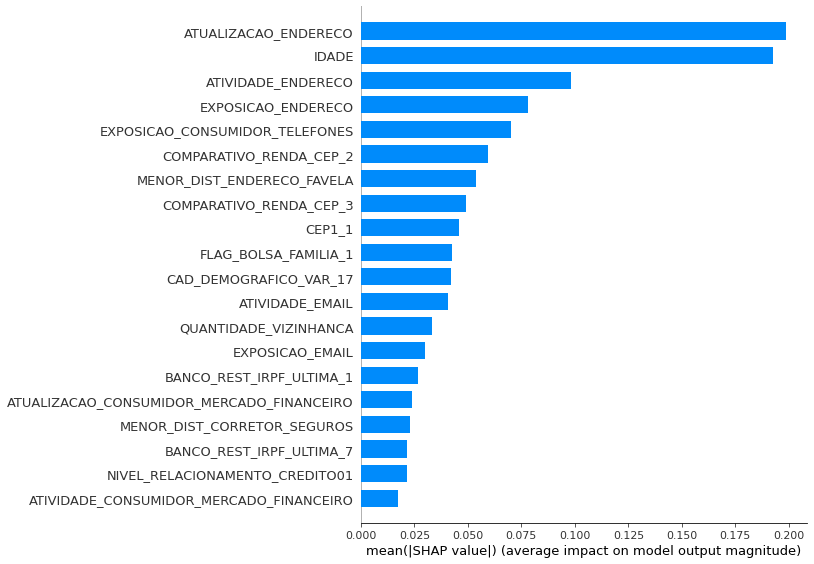

In [ ]:
shap.summary_plot(shap_values, X, plot_type="bar")

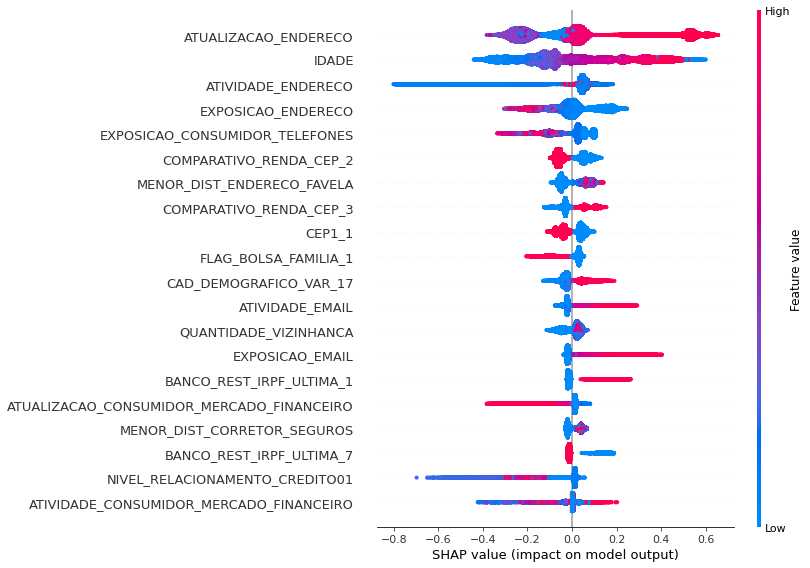

In [ ]:
shap.summary_plot(shap_values, X)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
rforest = RandomForestClassifier()
rforest.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
rforest_train_predict = rforest.predict(X)
y_test = test['IND_BOM_1_1']
X_test = test.drop(columns=['IND_BOM_1_1','IND_BOM_1_2'])
rforest_test_predict = rforest.predict(X_test)

In [ ]:
rforest.score(X_test,y_test)

0.6026662182201771

# MLP

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, InputLayer
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam
from tensorflow.keras.activations import relu, sigmoid, tanh, exponential

In [54]:
X = train.drop(columns=['IND_BOM_1_1','IND_BOM_1_2'])
y = train['IND_BOM_1_1']
input_dim = len(X.columns)

In [81]:
def baseline_model():
    model = Sequential()
    model.add(Dense(20, activation='tanh', input_dim=input_dim))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [82]:
model = baseline_model()

In [83]:
X_val = validation.drop(columns=['IND_BOM_1_1','IND_BOM_1_2'])
y_val = validation['IND_BOM_1_1']

In [86]:
model.fit(X, y, validation_data=(X_val, y_val), epochs=50, batch_size=200, verbose=2)

Epoch 1/50
1309/1309 - 3s - loss: 0.6464 - accuracy: 0.6248 - val_loss: 0.6817 - val_accuracy: 0.5785


TypeError: ignored

In [71]:
mlp_pred_class = model.predict(X_test)

NameError: ignored

In [72]:
y_pred = []
for x in mlp_pred_class:
  if x >= 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

NameError: ignored

In [ ]:
mlp_pred_class

In [ ]:
accuracy_score(y_test, y_pred)